![example](images/director_shot.jpeg)

In [1]:
# Import Relevant Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input, regularizers
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Ideas
1. FSM with one layer
    - Show with original data & augmented data
2. Next model: 
    - add two extra hidden layers
    - change to relu
    - try (L2) regularization & dropout
3. FSM CNN (with convolution)
4. Next CNN model, more convolutional layers and dropout
    - (assuming we're overfitting to train data) try regularization & dropout
    - futz with batch size and epochs


### Additional ideas
- AAB: try multiclass problem to identify viral, bacteria, or none

In [2]:
# # Running in Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/' 

In [3]:
# Running locally
root_path = '../'

In [4]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

## Generate augmented data to force model to be more generalizable

In [5]:
train_idg = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.20,
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                                   

train_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [14]:
# Don't augment the test set
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)

Found 624 images belonging to 2 classes.


In [6]:
classes = pd.DataFrame(train_set_aug.classes)
class_dict = {0:'Normal', 1:'Pneumonia'}
classes[0] = classes[0].map(class_dict)
classes.value_counts()

Pneumonia    3100
Normal       1073
dtype: int64

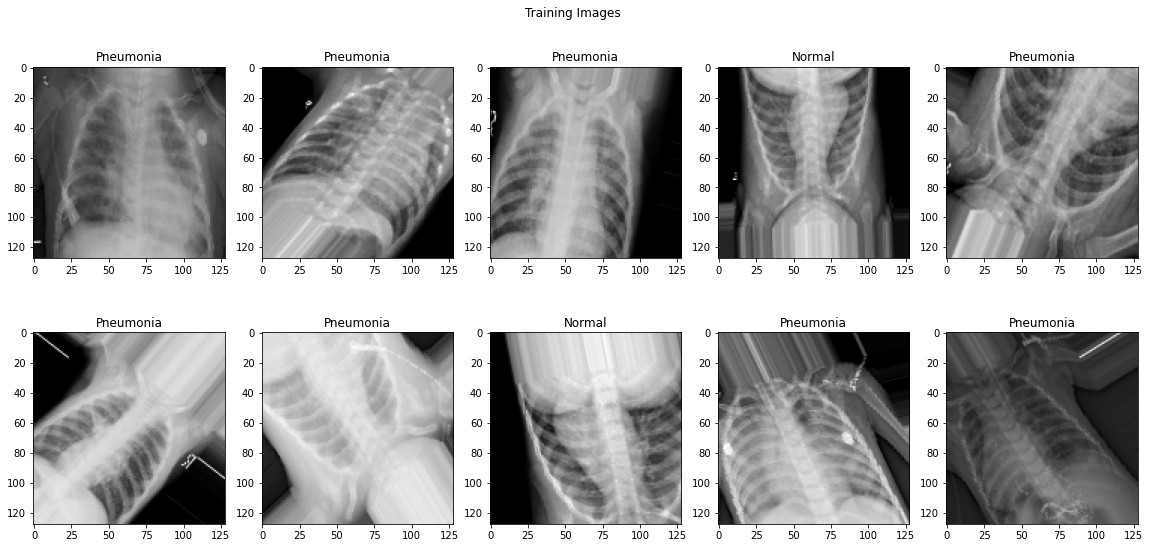

In [16]:
# # Visualize
train_images = train_set_aug.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
plt.savefig('../images/training_images_augmented.jpg', transparent = False, bbox_inches="tight")

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [8]:
# here you run your code to model the data
multilayer_reg_model_aug = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

multilayer_reg_model_aug.compile(optimizer='SGD',
                                 loss='binary_crossentropy',
                                 metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])



In [9]:
multilayer_reg_model_aug_results = multilayer_reg_model_aug.fit(
    train_set_aug, 
    epochs=100,
    batch_size=None, 
    verbose=1, 
    validation_data=validation_set_aug)

Epoch 1/100
131/131 [==============================] - 51s 391ms/step - loss: 0.6623 - accuracy: 0.7419 - recall: 0.9984 - precision: 0.7427 - true_positives: 3095.0000 - true_negatives: 1.0000 - false_positives: 1072.0000 - false_negatives: 5.0000 - auc: 0.5389 - val_loss: 0.6443 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6567
Epoch 2/100
131/131 [==============================] - 49s 376ms/step - loss: 0.6448 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.6073 - val_loss: 0.6455 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.7

131/131 [==============================] - 79s 602ms/step - loss: 0.5513 - accuracy: 0.7788 - recall: 0.9206 - precision: 0.8083 - true_positives: 2854.0000 - true_negatives: 396.0000 - false_positives: 677.0000 - false_negatives: 246.0000 - auc: 0.7837 - val_loss: 0.5405 - val_accuracy: 0.7910 - val_recall: 0.8942 - val_precision: 0.8359 - val_true_positives: 693.0000 - val_true_negatives: 132.0000 - val_false_positives: 136.0000 - val_false_negatives: 82.0000 - val_auc: 0.8042
Epoch 18/100
131/131 [==============================] - 80s 608ms/step - loss: 0.5379 - accuracy: 0.7930 - recall: 0.9252 - precision: 0.8194 - true_positives: 2868.0000 - true_negatives: 441.0000 - false_positives: 632.0000 - false_negatives: 232.0000 - auc: 0.8005 - val_loss: 0.6137 - val_accuracy: 0.7066 - val_recall: 0.7626 - val_precision: 0.8289 - val_true_positives: 591.0000 - val_true_negatives: 146.0000 - val_false_positives: 122.0000 - val_false_negatives: 184.0000 - val_auc: 0.7377
Epoch 19/100
131/1

131/131 [==============================] - 71s 544ms/step - loss: 0.5096 - accuracy: 0.8112 - recall: 0.9216 - precision: 0.8398 - true_positives: 2857.0000 - true_negatives: 528.0000 - false_positives: 545.0000 - false_negatives: 243.0000 - auc: 0.8247 - val_loss: 0.5566 - val_accuracy: 0.7728 - val_recall: 0.9652 - val_precision: 0.7808 - val_true_positives: 748.0000 - val_true_negatives: 58.0000 - val_false_positives: 210.0000 - val_false_negatives: 27.0000 - val_auc: 0.8074
Epoch 34/100
131/131 [==============================] - 72s 550ms/step - loss: 0.4957 - accuracy: 0.8133 - recall: 0.9232 - precision: 0.8410 - true_positives: 2862.0000 - true_negatives: 532.0000 - false_positives: 541.0000 - false_negatives: 238.0000 - auc: 0.8389 - val_loss: 0.5320 - val_accuracy: 0.7756 - val_recall: 0.8761 - val_precision: 0.8311 - val_true_positives: 679.0000 - val_true_negatives: 130.0000 - val_false_positives: 138.0000 - val_false_negatives: 96.0000 - val_auc: 0.8047
Epoch 35/100
131/131

131/131 [==============================] - 72s 551ms/step - loss: 0.4865 - accuracy: 0.8136 - recall: 0.9177 - precision: 0.8447 - true_positives: 2845.0000 - true_negatives: 550.0000 - false_positives: 523.0000 - false_negatives: 255.0000 - auc: 0.8439 - val_loss: 0.5114 - val_accuracy: 0.7843 - val_recall: 0.8658 - val_precision: 0.8472 - val_true_positives: 671.0000 - val_true_negatives: 147.0000 - val_false_positives: 121.0000 - val_false_negatives: 104.0000 - val_auc: 0.8293
Epoch 50/100
131/131 [==============================] - 71s 539ms/step - loss: 0.4796 - accuracy: 0.8176 - recall: 0.9181 - precision: 0.8488 - true_positives: 2846.0000 - true_negatives: 566.0000 - false_positives: 507.0000 - false_negatives: 254.0000 - auc: 0.8515 - val_loss: 0.5361 - val_accuracy: 0.7843 - val_recall: 0.9290 - val_precision: 0.8090 - val_true_positives: 720.0000 - val_true_negatives: 98.0000 - val_false_positives: 170.0000 - val_false_negatives: 55.0000 - val_auc: 0.8036
Epoch 51/100
131/13

131/131 [==============================] - 64s 487ms/step - loss: 0.4716 - accuracy: 0.8198 - recall: 0.9248 - precision: 0.8467 - true_positives: 2867.0000 - true_negatives: 554.0000 - false_positives: 519.0000 - false_negatives: 233.0000 - auc: 0.8527 - val_loss: 0.5120 - val_accuracy: 0.7948 - val_recall: 0.9445 - val_precision: 0.8106 - val_true_positives: 732.0000 - val_true_negatives: 97.0000 - val_false_positives: 171.0000 - val_false_negatives: 43.0000 - val_auc: 0.8232
Epoch 66/100
131/131 [==============================] - 65s 500ms/step - loss: 0.4778 - accuracy: 0.8112 - recall: 0.9165 - precision: 0.8430 - true_positives: 2841.0000 - true_negatives: 544.0000 - false_positives: 529.0000 - false_negatives: 259.0000 - auc: 0.8490 - val_loss: 0.5584 - val_accuracy: 0.7785 - val_recall: 0.9768 - val_precision: 0.7804 - val_true_positives: 757.0000 - val_true_negatives: 55.0000 - val_false_positives: 213.0000 - val_false_negatives: 18.0000 - val_auc: 0.8108
Epoch 67/100
131/131 

131/131 [==============================] - 75s 575ms/step - loss: 0.4573 - accuracy: 0.8164 - recall: 0.9074 - precision: 0.8545 - true_positives: 2813.0000 - true_negatives: 594.0000 - false_positives: 479.0000 - false_negatives: 287.0000 - auc: 0.8658 - val_loss: 0.4927 - val_accuracy: 0.7987 - val_recall: 0.9381 - val_precision: 0.8178 - val_true_positives: 727.0000 - val_true_negatives: 106.0000 - val_false_positives: 162.0000 - val_false_negatives: 48.0000 - val_auc: 0.8386
Epoch 82/100
131/131 [==============================] - 75s 569ms/step - loss: 0.4462 - accuracy: 0.8255 - recall: 0.9142 - precision: 0.8598 - true_positives: 2834.0000 - true_negatives: 611.0000 - false_positives: 462.0000 - false_negatives: 266.0000 - auc: 0.8735 - val_loss: 0.4916 - val_accuracy: 0.7881 - val_recall: 0.8645 - val_precision: 0.8524 - val_true_positives: 670.0000 - val_true_negatives: 152.0000 - val_false_positives: 116.0000 - val_false_negatives: 105.0000 - val_auc: 0.8401
Epoch 83/100
131/1

131/131 [==============================] - 69s 527ms/step - loss: 0.4521 - accuracy: 0.8227 - recall: 0.9139 - precision: 0.8569 - true_positives: 2833.0000 - true_negatives: 600.0000 - false_positives: 473.0000 - false_negatives: 267.0000 - auc: 0.8661 - val_loss: 0.4796 - val_accuracy: 0.8063 - val_recall: 0.9135 - val_precision: 0.8399 - val_true_positives: 708.0000 - val_true_negatives: 133.0000 - val_false_positives: 135.0000 - val_false_negatives: 67.0000 - val_auc: 0.8446
Epoch 98/100
131/131 [==============================] - 69s 525ms/step - loss: 0.4429 - accuracy: 0.8294 - recall: 0.9187 - precision: 0.8609 - true_positives: 2848.0000 - true_negatives: 613.0000 - false_positives: 460.0000 - false_negatives: 252.0000 - auc: 0.8740 - val_loss: 0.5061 - val_accuracy: 0.8044 - val_recall: 0.9755 - val_precision: 0.8034 - val_true_positives: 756.0000 - val_true_negatives: 83.0000 - val_false_positives: 185.0000 - val_false_negatives: 19.0000 - val_auc: 0.8518
Epoch 99/100
131/131

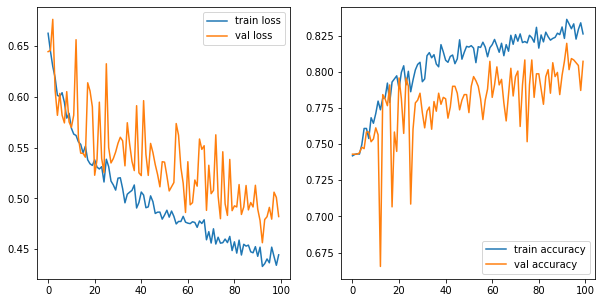

In [18]:
sigmoid_loss = multilayer_reg_model_aug_results.history['loss']
sigmoid_accuracy = multilayer_reg_model_aug_results.history['accuracy']
val_loss = multilayer_reg_model_aug_results.history['val_loss']
val_accuracy = multilayer_reg_model_aug_results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=multilayer_reg_model_aug_results.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=multilayer_reg_model_aug_results.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=multilayer_reg_model_aug_results.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=multilayer_reg_model_aug_results.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();
plt.savefig('../images/training_performance_multilayer_reg_model_aug.jpg', transparent = False, bbox_inches="tight")

In [15]:
multilayer_reg_model_aug.evaluate(test_set)

20/20 [==============================] - 5s 246ms/step - loss: 0.4702 - accuracy: 0.8077 - recall: 0.8718 - precision: 0.8293 - true_positives: 340.0000 - true_negatives: 164.0000 - false_positives: 70.0000 - false_negatives: 50.0000 - auc: 0.8878


[0.47023314237594604,
 0.807692289352417,
 0.8717948794364929,
 0.8292682766914368,
 340.0,
 164.0,
 70.0,
 50.0,
 0.887831449508667]

In [17]:
output_path = root_path + 'data/multilayer_reg_model_aug.h5'
multilayer_reg_model_aug.save(output_path)

# Appears that you also need to save history separately (untested)
# convert results.history to csv and save it out
hist_df = pd.DataFrame(multilayer_reg_model_aug_results.history)
hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)


# # https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('training.log', separator=',', append=False)
# model.fit(X_train, Y_train, callbacks=[csv_logger])

In [19]:
multilayer_reg_model_aug_results.history

{'loss': [0.6623439788818359,
  0.6448244452476501,
  0.6298177242279053,
  0.6187767386436462,
  0.6012683510780334,
  0.6002265214920044,
  0.6039381623268127,
  0.5943370461463928,
  0.5789386630058289,
  0.5835625529289246,
  0.5689936876296997,
  0.5632228851318359,
  0.561882495880127,
  0.5556544661521912,
  0.5530707240104675,
  0.5447337627410889,
  0.5512735247612,
  0.5379066467285156,
  0.5340036749839783,
  0.5324158072471619,
  0.5379226803779602,
  0.5307380557060242,
  0.528931736946106,
  0.5311629772186279,
  0.5161209106445312,
  0.5384882092475891,
  0.5312662720680237,
  0.5170440077781677,
  0.5132278203964233,
  0.5081459283828735,
  0.5198737978935242,
  0.5203089118003845,
  0.5096046328544617,
  0.4956602156162262,
  0.5040894746780396,
  0.5061002969741821,
  0.5078428387641907,
  0.5131921768188477,
  0.4905526638031006,
  0.49597498774528503,
  0.5062516331672668,
  0.5032877922058105,
  0.49082374572753906,
  0.49165037274360657,
  0.5024838447570801,
  0.